In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle

import robustness_model

/Users/sang-geon/Documents/UCI_BIASLab/HDC_Robustness/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
train_data.data.shape, train_data.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [6]:
X_train = X_train[(y_train == 0) | (y_train == 1)].reshape(-1, 28*28) / 255
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_test = X_test[(y_test == 0) | (y_test == 1)].reshape(-1, 28*28) / 255
y_test = y_test[(y_test == 0) | (y_test == 1)]

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([12665, 784]),
 torch.Size([12665]),
 torch.Size([2115, 784]),
 torch.Size([2115]))

In [8]:
original_dim = 28*28
dim = 10000

In [9]:
def gen_model_with_std(std):
  M = torch.empty(dim, original_dim, device='cpu').normal_(mean=0, std=std)
  encoder = robustness_model.FHRREncoder(original_dim, dim, M=M)
  model = robustness_model.ClassificationModel(encoder, in_dim=original_dim, dim=dim)
  return model

In [12]:
def overall_robustness(model: robustness_model.ClassificationModel, X):
    
    ep1s = []
    ep2s = []
    ep3s = []

    # L3 = model.get_lipschitz_constant()

    max_X, method2_history = model.get_lipschitz_constant_gd()
    L2 = method2_history[-1]
    max_X, L, method3_history = model.get_conservative_lipschitz_constant_gd()
    L3 = L

    plt.plot(method2_history)
    plt.ylabel('$|| \\nabla r(x) ||$')
    plt.xlabel('Iteration')
    plt.show()

    plt.plot(method3_history)
    plt.ylabel('$\\alpha$')
    plt.xlabel('Iteration')
    plt.show()
    
    for x in tqdm.tqdm(X):
        
        L1 = model.get_linear_approximation(x)
        # L2 = model.get_conservative_lipschitz_constant(x)

        ep1 = model.get_eps(x, L1)
        ep2 = model.get_eps(x, L2)
        ep3 = model.get_eps(x, L3)

        ep1s.append(ep1)
        ep2s.append(ep2)
        ep3s.append(ep3)
    
    return torch.tensor(ep1s), torch.tensor(ep2s), torch.tensor(ep3s)

In [10]:
model = gen_model_with_std(1.)
model.bundling(X_train, y_train)
# preds = model.predict(X_train)
# (preds == y_train).sum() / len(y_train)

max_X, L3, method3_history = model.get_conservative_lipschitz_constant_gd(epochs=8000, show_pbar=True)
avg_eps = torch.stack([model.get_eps(x, L3) for x in X_test]).mean()
print(avg_eps)

100%|██████████| 8000/8000 [00:28<00:00, 281.69it/s]


tensor(0.0158)


In [13]:
model_low = gen_model_with_std(0.1)
model_low.bundling(X_train, y_train)
# preds = model.predict(X_train)
# (preds == y_train).sum() / len(y_train)

max_X, L3, method3_history = model_low.get_conservative_lipschitz_constant_gd(epochs=8000, show_pbar=True)
avg_eps = torch.stack([model_low.get_eps(x, L3) for x in X_test]).mean()
print(avg_eps)

100%|██████████| 8000/8000 [00:28<00:00, 282.05it/s]


tensor(2.7891)


In [12]:
model_high = gen_model_with_std(2.)
model_high.bundling(X_train, y_train)
# preds = model.predict(X_train)
# (preds == y_train).sum() / len(y_train)

max_X, L3, method3_history = model_high.get_conservative_lipschitz_constant_gd(epochs=8000, show_pbar=True)
avg_eps = torch.stack([model_high.get_eps(x, L3) for x in X_test]).mean()
print(avg_eps)

100%|██████████| 8000/8000 [00:28<00:00, 281.91it/s]


tensor(0.0022)


In [14]:
train_accuracies = []
test_accuracies = []

train_accuracies_low = []
test_accuracies_low = []

train_accuracies_high = []
test_accuracies_high = []

noises = np.linspace(0, 1, 100)
for noise in tqdm.tqdm(noises):
    nvec = torch.empty_like(X_train[0]).normal_(0, 1)
    nvec *= noise / nvec.norm()

    preds = model.predict(X_train + nvec)
    train_acc = (preds == y_train).sum() / len(y_train)

    preds = model.predict(X_test + nvec)
    test_acc = (preds == y_test).sum() / len(y_test)

    #print(nvec.norm(), train_acc, test_acc)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    preds = model_low.predict(X_train + nvec)
    train_acc = (preds == y_train).sum() / len(y_train)

    preds = model_low.predict(X_test + nvec)
    test_acc = (preds == y_test).sum() / len(y_test)

    #print(nvec.norm(), train_acc, test_acc)

    train_accuracies_low.append(train_acc)
    test_accuracies_low.append(test_acc)

    preds = model_high.predict(X_train + nvec)
    train_acc = (preds == y_train).sum() / len(y_train)

    preds = model_high.predict(X_test + nvec)
    test_acc = (preds == y_test).sum() / len(y_test)

    #print(nvec.norm(), train_acc, test_acc)

    train_accuracies_high.append(train_acc)
    test_accuracies_high.append(test_acc)

100%|██████████| 100/100 [33:51<00:00, 20.32s/it]


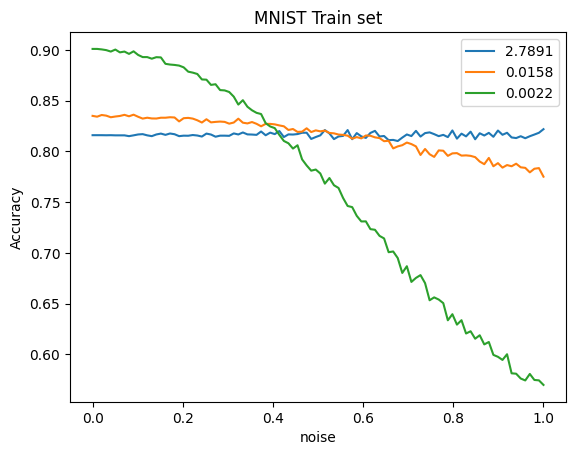

In [16]:
plt.figure(dpi=100)
plt.plot(noises, train_accuracies_low, label='2.7891')
plt.plot(noises, train_accuracies, label='0.0158')
plt.plot(noises, train_accuracies_high, label='0.0022')
plt.legend()
#plt.ylim([0.75, 0.85])
plt.title('MNIST Train set')
plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()

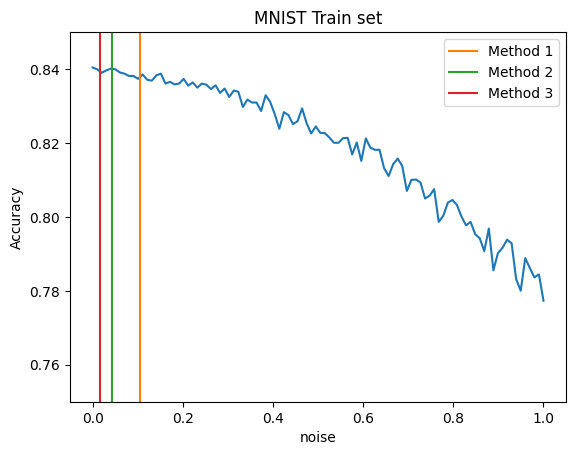

In [18]:
plt.figure(dpi=100)
plt.plot(noises, train_accuracies)
plt.plot([ep1s_train.mean(), ep1s_train.mean()], [0, 1], label='Method 1')
plt.plot([ep2s_train.mean(), ep2s_train.mean()], [0, 1], label='Method 2')
plt.plot([ep3s_train.mean(), ep3s_train.mean()], [0, 1], label='Method 3')
plt.legend()
plt.ylim([0.75, 0.85])
plt.title('MNIST Train set')
plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()

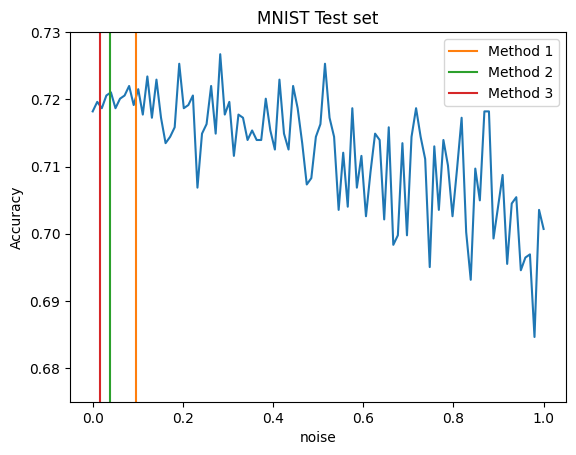

In [19]:
plt.figure(dpi=100)
plt.plot(noises, test_accuracies)
plt.plot([ep1s_test.mean(), ep1s_test.mean()], [0, 1], label='Method 1')
plt.plot([ep2s_test.mean(), ep2s_test.mean()], [0, 1], label='Method 2')
plt.plot([ep3s_test.mean(), ep3s_test.mean()], [0, 1], label='Method 3')
plt.legend()
plt.ylim([0.675, 0.73])
plt.title('MNIST Test set')
plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()